In [1]:
import io
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.optim.lr_scheduler import CosineAnnealingLR

from tqdm import tqdm
from torch import nn
from zipfile import ZipFile

In [2]:
dataset_name = 'dataset'
path_dataset = f"data/{dataset_name}.zip"

dataset_val = 'dataset_val'
path_dataset_val = f"data/{dataset_val}.zip"

In [3]:
def zip2ram(filename):
    """ Carga un archivo zip en memoria. Retorna un diccionario[str,bytes] """
    result = {}
    with ZipFile(filename, mode="r") as archive:
        for info in archive.infolist():
            key = info.filename
            value = archive.read(key)
            result[key] = value
    return result

dataset = zip2ram(path_dataset)
val_dataset = zip2ram(path_dataset_val)

(4, 512, 512, 1) (4, 512, 512, 2) (4, 512, 512, 1)
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
float32 float32 float32
3.0722656 1.0 2.4042969


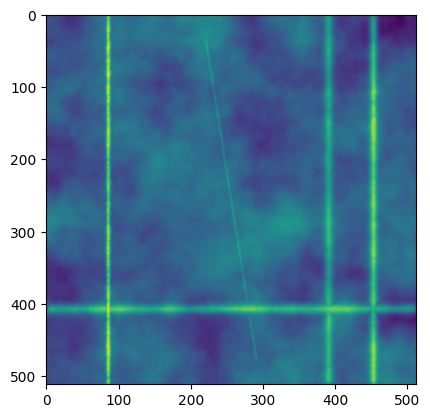

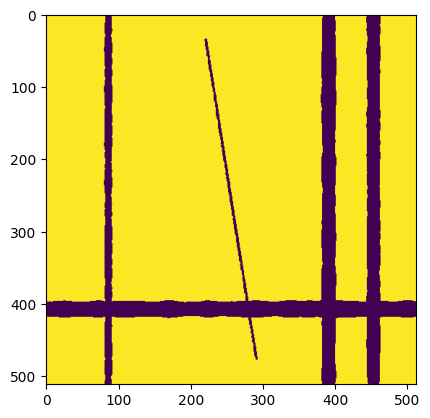

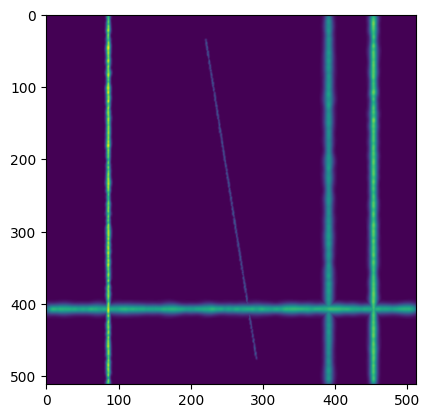

In [4]:
def get_image_batch(dataset, batch_size=32):
    size_dataset = len(dataset.keys()) // 4  # 1 input + 3 outputs
    input, output_1, output_2 = [], [], []

    idxs = np.random.choice(range(size_dataset), batch_size, replace=False)

    for idx in idxs:
        key_input = f'img_{idx}.npz'
        key_output_pretil = f'img_pretil_{idx}.npz'
        key_outputs = [f'img_backgound_{idx}.png', f'img_pretil_binary_{idx}.png']

        byte_input = dataset.get(key_input)
        load_bytes = io.BytesIO(byte_input)
        input_image = np.load(load_bytes, allow_pickle=True)['arr_0']

        byte_output_pretil  = dataset.get(key_output_pretil)
        load_bytes = io.BytesIO(byte_output_pretil)
        output_pretil = np.load(load_bytes, allow_pickle=True)['arr_0']

        outputs = []
        for key_output in key_outputs:
            byte_output = dataset.get(key_output)
            if byte_output:
                output = cv2.imdecode(np.frombuffer(byte_output, dtype="uint8"), cv2.IMREAD_GRAYSCALE)
                outputs.append(output)
        
        outputs_binary = np.stack((outputs[0],outputs[1]),axis=-1)
        output_1.append(outputs_binary)
        output_2.append(np.expand_dims(output_pretil, axis=-1))  
        input.append(np.expand_dims(input_image, axis=-1))
        
    return np.array(input, dtype=np.float32), np.array(output_1, dtype=np.float32) / 255, np.array(output_2, dtype=np.float32)

i, o1, o2 = get_image_batch(dataset, 4)
print(i.shape, o1.shape, o2.shape)
print(type(i), type(o1), type(o2))
print(i.dtype, o1.dtype, o2.dtype)
print(np.max(i), np.max(o1), np.max(o2))

plt.figure()
plt.imshow(i[0])
plt.figure()
plt.imshow(o1[0,:,:,0])
plt.figure()
plt.imshow(o2[0])

In [5]:
INPLACE=False 
CONVPAD='zeros'

def pt_get_activation(activation) -> nn.Module:
    """ Retorna un modulo de activacion por nombre.
    Retorna None si el nombre no coincide """
    if(activation is None): return None
    elif isinstance(activation,nn.Module): return activation
    elif(activation=='relu'): return nn.ReLU(inplace=INPLACE)
    elif(activation=='elu'): return nn.ELU(inplace=INPLACE)
    elif(activation=='leakyrelu'): return nn.LeakyReLU(inplace=INPLACE)
    elif(activation=='sigmoid'): return nn.Sigmoid()
    elif(activation=='logsigmoid'): return nn.LogSigmoid()
    elif(activation=='softmax'): return nn.Softmax(dim=1)
    elif(activation=='softmin'): return nn.Softmin(dim=1)
    elif(activation=='logsoftmax'): return nn.LogSoftmax(dim=1)
    elif(activation=='prelu'): return nn.PReLU()
    elif(activation=='relu6'): return nn.ReLU6(inplace=INPLACE)
    elif(activation=='rrelu'): return nn.RReLU(inplace=INPLACE)
    elif(activation=='selu'): return nn.SELU(inplace=INPLACE)
    elif(activation=='celu'): return nn.CELU(inplace=INPLACE)
    elif(activation=='gelu'): return nn.GELU(approximate='tanh')
    elif(activation=='silu'): return nn.SiLU(inplace=INPLACE)
    elif(activation=='mish'): return nn.Mish(inplace=INPLACE)
    elif(activation=='softplus'): return nn.Softplus()
    elif(activation=='softsign'): return nn.Softsign()
    elif(activation=='softshrink'): return nn.Softshrink()
    elif(activation=='tanh'): return nn.Tanh()
    return None

class Conv(nn.Module):
    """ Convolution + Activation """
        
    def __init__(self, ic:int, oc:int, k=3, s=1, p=1, bias=True, activation=None, scale=None, residual=False):
        super().__init__()
        self.conv = nn.Conv2d(ic, oc, kernel_size=k, stride=s, padding=p, bias=bias, padding_mode=CONVPAD)
        self.activation = pt_get_activation(activation)
        self.scale = scale
        self.residual = residual
        
    def forward(self, x):
        x0 = x
        x = self.conv(x)
        if(self.activation is not None): x = self.activation(x)
        if(self.scale is not None): x = self.scale(x)
        if(self.residual): x = x0 + x
        return x
    
class ResID07(nn.Module):
    """ Bloque residual bn+act+conv+bn+act+conv con ajuste de dimensiones espaciales y semanticas """ 
    def __init__(self, ic:int, oc:int, activation='relu', dropout=0.0, expansion=1, resample=None):
        super().__init__()
        mc = int(ic*expansion)
        self.norm1 = torch.nn.BatchNorm2d(ic, momentum=0.01)
        self.act1  = pt_get_activation(activation) 
        self.conv1 = Conv(ic,mc,k=3,s=1,p=1)
        
        self.resample = resample
        
        self.norm2 = torch.nn.BatchNorm2d(mc, momentum=0.01)
        self.act2  = pt_get_activation(activation)
        self.dropout = nn.Dropout(dropout) if dropout>0.0 else None
        self.conv2 = Conv(mc,oc,k=3,s=1,p=1)
        
        self.conv3 = Conv(ic,oc,k=1,s=1,p=0) if ic!=oc else None
        
    def forward(self, x, emb=None):
        x0 = x
        if(self.norm1 is not None): x = self.norm1(x)
        if(self.act1  is not None): x = self.act1(x)
        x = self.conv1(x)
        
        if(emb is not None): x = x+emb
        
        if(self.resample is not None):
            x  = F.interpolate(x, scale_factor=self.resample, mode='bilinear')
            x0 = F.interpolate(x0,scale_factor=self.resample, mode='bilinear')
        
        if(self.norm2   is not None): x = self.norm2(x)
        if(self.act2    is not None): x = self.act2(x)
        if(self.dropout is not None): x = self.dropout(x)
        x = self.conv2(x)
        
        if self.conv3 is not None: x0 = self.conv3(x0) #(b,oc,h,w) Ajusta los canales para que sean iguales.
        
        return x0 + x
    
class ResID07N(nn.Module):
    """ N bloques ResID07 """
    def __init__(self, ic:int, n=2, activation='relu', dropout=0.0, expansion=2):
        super().__init__()
        self.layers = []
        for _ in range(n): self.layers.append(ResID07(ic,ic, activation=activation, dropout=dropout, expansion=expansion))
        self.layers = nn.Sequential(*self.layers)

    def forward(self, x):
        return self.layers(x)

class UNetSam(nn.Module):
    """ UNET
    La primera seccion aplica ResID07 con resample=0.5 varias veces para reducir  la resolucion y aumentar la cantidad de filtros, hasta llegar a la maxima cantidad de filtros.
    La segunda seccion aplica ResID07 con resample=2.0 varias veces para aumentar la resolucion y reducir  la cantidad de filtros.
    Agrega enlaces entre la primera y segunda seccion.
    Retorna una lista 'y' con todas las salidas de cada nivel, siendo y[0] la entrada e y[-1] la ultima salida
    activation2: Activacion de SAM: sigmoid, softmax8, softmax16, softmax32
    """
    
    def __init__(self, filters=(1,16,32,64,128,256,128,64,32,16), n=1, activation='relu', dropout=0.0, expansion=1):
        super().__init__()
        c = len(filters) #Total de filtros
        j = np.argmax(filters) #Indice de la mayor cantidad de filtros (Parte mas ancha de la UNet)
        
        self.convs = nn.ModuleList() #Lista de modulos ConvBnAct
        self.convs_res = nn.ModuleList() #Lista de modulos ResID01N

        for i in range(1,j+1):
            f1 = filters[i-1]
            f2 = filters[i]
            self.convs.append( ResID07(f1,f2,resample=0.5,activation=activation, dropout=dropout, expansion=expansion))
            module = ResID07N(f2,n=n,activation=activation, dropout=dropout, expansion=expansion)
            self.convs_res.append(module)
            
        self.convts = nn.ModuleList() #Lista de modulos ConvTBnAct (Convolucion Transpuesta)
        self.convts_res = nn.ModuleList() #Lista de modulos ResID01N
        self.links = nn.ModuleList() #Lista de modulos ConvBnAct para enlazar la primera seccion con la segunda
        for i in range(j+1,c):
            f1 = filters[i-1]
            f2 = filters[i]
            self.convts.append(ResID07(f1,f2,resample=2,activation=activation, dropout=dropout, expansion=expansion))
            module = ResID07N(f2,n=n,activation=activation, dropout=dropout, expansion=expansion)
            self.convts_res.append(module)
            self.links.append(ResID07N(f2,n=n,activation=activation, dropout=dropout, expansion=expansion))
            
        self.c = c #Total de filtros
        self.j = j #Indice de la mayor cantidad de filtros

    def forward(self, x):
        """ x:(b,c,h,w) """

        y = [x] #Lista de salidas. El primer valor de salida es la entrada
        g=0
        for conv,res  in zip(self.convs, self.convs_res): #Por cada convolucion de la primera seccion
            x = conv(x) #Aplica la convolucion
            
            x = res(x) #Aplica residual
            y.append(x) #Guarda la salida
            
        i=1
        j=self.j
        for convt,res,link in zip(self.convts, self.convts_res, self.links): #Por cada convolucion transpuesta y enlace
            x = convt(x) #Aplica la convolucion transpuesta 
            
            x = res(x) #Aplica residual
            if(j-i>=0): x=x+link(y[j-i]) #Aplica el enlace a la primera seccion
            i+=1
            y.append(x) #Guarda la salida
        
        return y #Retorna una lista con todas las salidas
    

class Unet(nn.Module):
    def __init__(self, ):
        super().__init__()
        self.unet = UNetSam(filters=(1,16,32,64,128,256,128,64,32,16), n=1, activation='relu', dropout=0.0, expansion=1)
        self.convT_o1 = nn.ConvTranspose2d(16, 2, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.convT_o2 = nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1)
        

    def forward(self, x):
        x -=  F.avg_pool2d(x, 101, stride=1, padding=50)
        y = self.unet(x)
        y1 = self.convT_o1(y[-1])
        output_pretil = self.convT_o2(y[-1])

        output_binary = F.softmax(y1, dim=1)        
        return output_binary, output_pretil

model = Unet()
model.cuda()
print('Model load on vram')

Model load on vram


In [6]:
def pt_loss_mse(y_pred, y_true):
    """ Mean of Square Error. Retorna un scalar  """
    return F.mse_loss(y_pred, y_true, reduction='mean') #Retorna un scalar

def pt_loss_mbce(y_pred, y_true):
    """ Mean of Binary Cross Entropy. Retorna un scalar  """
    return F.binary_cross_entropy(y_pred, y_true, reduction='mean')

def pt_bce2(yp, yt, eps=1e-8):
    """ Binary Cross Entropy con recorte entre eps y 1-eps para evitar errores numericos en el logaritmo. Retorna un tensor con la misma forma que yp """
    epsc = 1-eps
    yp  = torch.clip(yp,eps,epsc)
    ypc = torch.clip(1-yp,eps,epsc)
    loss = yt*torch.log(yp)+(1-yt)*torch.log(ypc)
    return -loss

def pt_loss_mbce2(yp, yt, eps=1e-8):    
    """ Mean Binary Cross Entropy con recorte entre eps y 1-eps para evitar errores numericos en el logaritmo. Retorna un scalar  """
    return pt_bce2(yp, yt, eps).mean()

In [7]:
import torch
import torch.nn.functional as F

def evaluate_model(model, val_dataset, batch_size, device):
    model.eval()
    total_loss = 0
    total_loss1 = 0
    total_loss2 = 0
    total_tp = 0
    total_fp = 0
    total_fn = 0
    num_batches = len(val_dataset.keys()) // batch_size

    with torch.no_grad():
        for i in range(0, len(val_dataset.keys()), batch_size):
            input_image, output_binary, output_pretil = get_image_batch(val_dataset, batch_size)

            # Preprocesamiento
            input_image = torch.tensor(input_image, dtype=torch.float32, device=device)
            output_binary = torch.tensor(output_binary, dtype=torch.float32, device=device)
            output_pretil = torch.tensor(output_pretil, dtype=torch.float32, device=device)
            input_image = input_image.permute(0, 3, 1, 2)
            output_binary = output_binary.permute(0, 3, 1, 2)
            output_pretil = output_pretil.permute(0, 3, 1, 2)

            # Forward
            pred_binary, pred_pretil = model(input_image)

            # Loss
            loss1 = pt_loss_mbce2(pred_binary, output_binary)
            loss2 = pt_loss_mse(pred_pretil, output_pretil)
            loss = loss1 + loss2

            total_loss += loss.item()
            total_loss1 += loss1.item()
            total_loss2 += loss2.item()

            pred_binary = (pred_binary > 0.5).float()
            tp = ((pred_binary == 1) & (output_binary == 1)).sum().item()
            fp = ((pred_binary == 1) & (output_binary == 0)).sum().item()
            fn = ((pred_binary == 0) & (output_binary == 1)).sum().item()

            total_tp += tp
            total_fp += fp
            total_fn += fn

    avg_loss = total_loss / num_batches
    avg_loss1 = total_loss1 / num_batches
    avg_loss2 = total_loss2 / num_batches

    precision = total_tp / (total_tp + total_fp) if (total_tp + total_fp) > 0 else 0
    recall = total_tp / (total_tp + total_fn) if (total_tp + total_fn) > 0 else 0

    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0


    model.train()
    return avg_loss, avg_loss1, avg_loss2, precision, recall, f1_score


In [20]:
def testing(real_img, mask, epoch_idx, device):
    real_img = np.expand_dims(real_img, -1)
    real_img = np.expand_dims(real_img, 0)
    real_img = torch.tensor(real_img, dtype=torch.float32, device=device)
    real_img = real_img.permute(0,3,1,2)

    binary, pretil = model(real_img) 
    pretil_img = pretil[0].cpu().detach().numpy().transpose(1, 2, 0)
    binary_img = binary[0].cpu().detach().numpy().transpose(1, 2, 0)[:,:,1]
    binary_img *= mask 
    mask = np.expand_dims(mask, -1)
    pretil_img *= mask
    pretil_img = (np.clip(pretil_img,0,1) * 255).astype(np.uint8)
    binary_img = (np.clip(binary_img,0,1) * 255).astype(np.uint8)    

    cv2.imwrite(f'testing/pretil_epoch_{epoch_idx}.png',pretil_img)
    cv2.imwrite(f'testing/binary_epoch_{epoch_idx}.png',binary_img)

In [9]:
def augment(img_input, img_binary, img_pretil, p=0.5):
    img_input_, img_binary_, img_pretil_ = [], [], []
    p_ = (p-0.2) if (p-0.3) > 0 else 0.2
    for i in range(len(img_input)):
        img_input_i = img_input[i]
        img_binary_i = img_binary[i]
        img_pretil_i = img_pretil[i]

        height, width = img_input_i.shape[:2]

        # Generar un círculo con probabilidad p_
        if np.random.rand() < p:
            center = (np.random.randint(0, width), np.random.randint(0, height))
            radius = np.random.randint(10, min(height, width) // 2)
            mean_value = np.mean(img_input_i)
            cv2.circle(img_input_i, center, radius, int(mean_value), -1)
            cv2.circle(img_binary_i, center, radius, (1,0), -1)
            cv2.circle(img_pretil_i, center, radius, 0, -1)

        # Generar un rectángulo con probabilidad p_
        if np.random.rand() < p:
            pt1 = (np.random.randint(0, width), np.random.randint(0, height))
            pt2 = (np.random.randint(0, width), np.random.randint(0, height))
            mean_value = np.mean(img_input_i)
            cv2.rectangle(img_input_i, pt1, pt2, int(mean_value), -1)
            cv2.rectangle(img_binary_i, pt1, pt2, (1,0), -1)
            cv2.rectangle(img_pretil_i, pt1, pt2, 0, -1)

        # Generar un triángulo con probabilidad p_
        if np.random.rand() < p:
            pt1 = (np.random.randint(0, width), np.random.randint(0, height))
            pt2 = (np.random.randint(0, width), np.random.randint(0, height))
            pt3 = (np.random.randint(0, width), np.random.randint(0, height))
            triangle_cnt = np.array([pt1, pt2, pt3], dtype=np.int32)
            mean_value = np.mean(img_input_i)
            cv2.fillPoly(img_input_i, [triangle_cnt], int(mean_value))
            cv2.fillPoly(img_binary_i, [triangle_cnt], (1,0))
            cv2.fillPoly(img_pretil_i, [triangle_cnt], 0)

        # Generar un polígono irregular con probabilidad p
        if np.random.rand() < p_:
            num_points = np.random.randint(5, 10)  # Número de puntos del polígono
            points = []
            for _ in range(num_points):
                points.append((np.random.randint(0, width), np.random.randint(0, height)))
            irregular_polygon = np.array(points, dtype=np.int32)
            mean_value = np.mean(img_input_i)
            cv2.fillPoly(img_input_i, [irregular_polygon], int(mean_value))
            cv2.fillPoly(img_binary_i, [irregular_polygon], (1,0))
            cv2.fillPoly(img_pretil_i, [irregular_polygon], 0)

        # Flip horizontal con probabilidad p
        if np.random.rand() < p:
            img_input_i = np.fliplr(img_input_i)
            img_binary_i = np.fliplr(img_binary_i)
            img_pretil_i = np.fliplr(img_pretil_i)

        # Flip vertical con probabilidad p
        if np.random.rand() < p:
            img_input_i = np.flipud(img_input_i).copy()
            img_binary_i = np.flipud(img_binary_i).copy()
            img_pretil_i = np.flipud(img_pretil_i).copy()

        img_input_.append(img_input_i)
        img_binary_.append(img_binary_i)
        img_pretil_.append(img_pretil_i)

    return np.array(img_input_), np.array(img_binary_), np.array(img_pretil_)

In [10]:
epochs = 100
batch_size = 25
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

real_img = np.load('dem.npz')["dem"]
mask_dem_img = np.load('dem.npz')["mask"]

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
scheduler = CosineAnnealingLR(optimizer, T_max=epochs, eta_min=1e-4)

val_losses = []
train_losses = []

for epoch in range(epochs):
    model.train()
    epoch_train_loss = 0
    for i in tqdm(range(0, len(dataset.keys()) // 4, batch_size), desc=f"Epoch {epoch+1}/{epochs} Training"):
       
        input_image, output_binary, output_pretil  = get_image_batch(dataset, batch_size)
        input_image, output_binary, output_pretil = augment(input_image, output_binary, output_pretil)

        # Preprocesamiento
        input_image = torch.tensor(input_image, dtype=torch.float32, device=device)
        output_binary = torch.tensor(output_binary, dtype=torch.float32, device=device)
        output_pretil = torch.tensor(output_pretil, dtype=torch.float32, device=device)
        input_image = input_image.permute(0, 3, 1, 2)
        output_binary = output_binary.permute(0, 3, 1, 2)
        output_pretil = output_pretil.permute(0, 3, 1, 2)
        
        # Forward
        pred_binary, pred_pretil = model(input_image)
        
        # Loss
        loss1 = pt_loss_mbce2(pred_binary, output_binary)
        loss2 = pt_loss_mse(pred_pretil, output_pretil)
        loss = loss1 + loss2
        epoch_train_loss += loss.item()
        
        # Backward
        loss.backward() # Calcula los gradientes
        
        trainable_parameters = [] #parametros entrenables
        for pg in optimizer.param_groups: trainable_parameters += pg['params'] #Lista de parametros a optimizar
        grads = [p.grad for p in trainable_parameters if p.grad is not None]
        
        with torch.no_grad():
            for grad in grads: 
                grad.nan_to_num_(0.0, 1.0, -1.0) #Reemplaza los valores Nan, INF y -INF

        torch.nn.utils.clip_grad_value_(model.parameters(), 1) # Evita el exploding gradient
        optimizer.step() # Actualiza los pesos
        optimizer.zero_grad()
        scheduler.step()

    train_losses.append(epoch_train_loss / (len(dataset.keys()) // batch_size))

    # Validation
    val_loss, _, _, precision, recall, f1_score = evaluate_model(model, val_dataset, batch_size, device)
    val_losses.append(val_loss)

    model.eval()
    testing(real_img, mask_dem_img, epoch, device)
    model.train()

    torch.save(model.state_dict(), f'weigths/model_epoch_{epoch+1}.pth')

    print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1_score:.4f}')

Epoch 1/100 Training: 100%|██████████| 400/400 [01:56<00:00,  3.44it/s]


Epoch 1/100, Train Loss: 0.0671, Val Loss: 0.0555, Precision: 0.9837, Recall: 0.9837, F1 Score: 0.9837


Epoch 2/100 Training: 100%|██████████| 400/400 [01:48<00:00,  3.69it/s]


Epoch 2/100, Train Loss: 0.0102, Val Loss: 0.0410, Precision: 0.9874, Recall: 0.9874, F1 Score: 0.9874


Epoch 3/100 Training: 100%|██████████| 400/400 [01:53<00:00,  3.53it/s]


Epoch 3/100, Train Loss: 0.0077, Val Loss: 0.0369, Precision: 0.9890, Recall: 0.9890, F1 Score: 0.9890


Epoch 4/100 Training: 100%|██████████| 400/400 [01:55<00:00,  3.46it/s]


Epoch 4/100, Train Loss: 0.0064, Val Loss: 0.0255, Precision: 0.9915, Recall: 0.9915, F1 Score: 0.9915


Epoch 5/100 Training: 100%|██████████| 400/400 [01:53<00:00,  3.53it/s]


Epoch 5/100, Train Loss: 0.0055, Val Loss: 0.0230, Precision: 0.9928, Recall: 0.9928, F1 Score: 0.9928


Epoch 6/100 Training: 100%|██████████| 400/400 [01:52<00:00,  3.56it/s]


Epoch 6/100, Train Loss: 0.0054, Val Loss: 0.0280, Precision: 0.9924, Recall: 0.9924, F1 Score: 0.9924


Epoch 7/100 Training: 100%|██████████| 400/400 [01:50<00:00,  3.62it/s]


Epoch 7/100, Train Loss: 0.0047, Val Loss: 0.0210, Precision: 0.9929, Recall: 0.9929, F1 Score: 0.9929


Epoch 8/100 Training: 100%|██████████| 400/400 [01:46<00:00,  3.74it/s]


Epoch 8/100, Train Loss: 0.0043, Val Loss: 0.0330, Precision: 0.9897, Recall: 0.9897, F1 Score: 0.9897


Epoch 9/100 Training: 100%|██████████| 400/400 [01:50<00:00,  3.62it/s]


Epoch 9/100, Train Loss: 0.0041, Val Loss: 0.0212, Precision: 0.9923, Recall: 0.9923, F1 Score: 0.9923


Epoch 10/100 Training: 100%|██████████| 400/400 [01:53<00:00,  3.52it/s]


Epoch 10/100, Train Loss: 0.0038, Val Loss: 0.0191, Precision: 0.9942, Recall: 0.9942, F1 Score: 0.9942


Epoch 11/100 Training: 100%|██████████| 400/400 [01:55<00:00,  3.46it/s]


Epoch 11/100, Train Loss: 0.0038, Val Loss: 0.0167, Precision: 0.9938, Recall: 0.9938, F1 Score: 0.9938


Epoch 12/100 Training: 100%|██████████| 400/400 [01:54<00:00,  3.50it/s]


Epoch 12/100, Train Loss: 0.0038, Val Loss: 0.0210, Precision: 0.9936, Recall: 0.9936, F1 Score: 0.9936


Epoch 13/100 Training: 100%|██████████| 400/400 [01:49<00:00,  3.66it/s]


Epoch 13/100, Train Loss: 0.0034, Val Loss: 0.0174, Precision: 0.9934, Recall: 0.9934, F1 Score: 0.9934


Epoch 14/100 Training: 100%|██████████| 400/400 [01:51<00:00,  3.58it/s]


Epoch 14/100, Train Loss: 0.0033, Val Loss: 0.0140, Precision: 0.9948, Recall: 0.9948, F1 Score: 0.9948


Epoch 15/100 Training: 100%|██████████| 400/400 [01:53<00:00,  3.53it/s]


Epoch 15/100, Train Loss: 0.0031, Val Loss: 0.0182, Precision: 0.9940, Recall: 0.9940, F1 Score: 0.9940


Epoch 16/100 Training: 100%|██████████| 400/400 [01:51<00:00,  3.58it/s]


Epoch 16/100, Train Loss: 0.0030, Val Loss: 0.0144, Precision: 0.9945, Recall: 0.9945, F1 Score: 0.9945


Epoch 17/100 Training: 100%|██████████| 400/400 [01:53<00:00,  3.53it/s]


Epoch 17/100, Train Loss: 0.0029, Val Loss: 0.0124, Precision: 0.9952, Recall: 0.9952, F1 Score: 0.9952


Epoch 18/100 Training: 100%|██████████| 400/400 [01:52<00:00,  3.57it/s]


Epoch 18/100, Train Loss: 0.0028, Val Loss: 0.0127, Precision: 0.9952, Recall: 0.9952, F1 Score: 0.9952


Epoch 19/100 Training: 100%|██████████| 400/400 [01:46<00:00,  3.74it/s]


Epoch 19/100, Train Loss: 0.0028, Val Loss: 0.0161, Precision: 0.9940, Recall: 0.9940, F1 Score: 0.9940


Epoch 20/100 Training: 100%|██████████| 400/400 [01:46<00:00,  3.75it/s]


Epoch 20/100, Train Loss: 0.0027, Val Loss: 0.0157, Precision: 0.9943, Recall: 0.9943, F1 Score: 0.9943


Epoch 21/100 Training: 100%|██████████| 400/400 [01:46<00:00,  3.75it/s]


Epoch 21/100, Train Loss: 0.0027, Val Loss: 0.0123, Precision: 0.9954, Recall: 0.9954, F1 Score: 0.9954


Epoch 22/100 Training: 100%|██████████| 400/400 [01:46<00:00,  3.75it/s]


Epoch 22/100, Train Loss: 0.0025, Val Loss: 0.0128, Precision: 0.9951, Recall: 0.9951, F1 Score: 0.9951


Epoch 23/100 Training: 100%|██████████| 400/400 [01:47<00:00,  3.73it/s]


Epoch 23/100, Train Loss: 0.0026, Val Loss: 0.0115, Precision: 0.9955, Recall: 0.9955, F1 Score: 0.9955


Epoch 24/100 Training: 100%|██████████| 400/400 [01:46<00:00,  3.75it/s]


Epoch 24/100, Train Loss: 0.0025, Val Loss: 0.0169, Precision: 0.9935, Recall: 0.9935, F1 Score: 0.9935


Epoch 25/100 Training: 100%|██████████| 400/400 [01:46<00:00,  3.75it/s]


Epoch 25/100, Train Loss: 0.0024, Val Loss: 0.0163, Precision: 0.9939, Recall: 0.9939, F1 Score: 0.9939


Epoch 26/100 Training: 100%|██████████| 400/400 [01:46<00:00,  3.76it/s]


Epoch 26/100, Train Loss: 0.0025, Val Loss: 0.0116, Precision: 0.9954, Recall: 0.9954, F1 Score: 0.9954


Epoch 27/100 Training: 100%|██████████| 400/400 [01:46<00:00,  3.76it/s]


Epoch 27/100, Train Loss: 0.0023, Val Loss: 0.0138, Precision: 0.9945, Recall: 0.9945, F1 Score: 0.9945


Epoch 28/100 Training: 100%|██████████| 400/400 [01:46<00:00,  3.76it/s]


Epoch 28/100, Train Loss: 0.0024, Val Loss: 0.0186, Precision: 0.9930, Recall: 0.9930, F1 Score: 0.9930


Epoch 29/100 Training: 100%|██████████| 400/400 [01:46<00:00,  3.75it/s]


Epoch 29/100, Train Loss: 0.0024, Val Loss: 0.0124, Precision: 0.9957, Recall: 0.9957, F1 Score: 0.9957


Epoch 30/100 Training: 100%|██████████| 400/400 [01:46<00:00,  3.75it/s]


Epoch 30/100, Train Loss: 0.0023, Val Loss: 0.0134, Precision: 0.9947, Recall: 0.9947, F1 Score: 0.9947


Epoch 31/100 Training: 100%|██████████| 400/400 [01:46<00:00,  3.75it/s]


Epoch 31/100, Train Loss: 0.0022, Val Loss: 0.0115, Precision: 0.9956, Recall: 0.9956, F1 Score: 0.9956


Epoch 32/100 Training: 100%|██████████| 400/400 [01:46<00:00,  3.75it/s]


Epoch 32/100, Train Loss: 0.0022, Val Loss: 0.0116, Precision: 0.9955, Recall: 0.9955, F1 Score: 0.9955


Epoch 33/100 Training: 100%|██████████| 400/400 [01:46<00:00,  3.75it/s]


Epoch 33/100, Train Loss: 0.0022, Val Loss: 0.0114, Precision: 0.9954, Recall: 0.9954, F1 Score: 0.9954


Epoch 34/100 Training: 100%|██████████| 400/400 [01:46<00:00,  3.75it/s]


Epoch 34/100, Train Loss: 0.0022, Val Loss: 0.0108, Precision: 0.9957, Recall: 0.9957, F1 Score: 0.9957


Epoch 35/100 Training: 100%|██████████| 400/400 [01:46<00:00,  3.75it/s]


Epoch 35/100, Train Loss: 0.0022, Val Loss: 0.0102, Precision: 0.9959, Recall: 0.9959, F1 Score: 0.9959


Epoch 36/100 Training: 100%|██████████| 400/400 [01:46<00:00,  3.75it/s]


Epoch 36/100, Train Loss: 0.0021, Val Loss: 0.0804, Precision: 0.9725, Recall: 0.9725, F1 Score: 0.9725


Epoch 37/100 Training: 100%|██████████| 400/400 [01:46<00:00,  3.75it/s]


Epoch 37/100, Train Loss: 0.0021, Val Loss: 0.0097, Precision: 0.9960, Recall: 0.9960, F1 Score: 0.9960


Epoch 38/100 Training: 100%|██████████| 400/400 [01:46<00:00,  3.76it/s]


Epoch 38/100, Train Loss: 0.0020, Val Loss: 0.0114, Precision: 0.9954, Recall: 0.9954, F1 Score: 0.9954


Epoch 39/100 Training: 100%|██████████| 400/400 [01:47<00:00,  3.72it/s]


Epoch 39/100, Train Loss: 0.0021, Val Loss: 0.0118, Precision: 0.9955, Recall: 0.9955, F1 Score: 0.9955


Epoch 40/100 Training: 100%|██████████| 400/400 [01:51<00:00,  3.59it/s]


Epoch 40/100, Train Loss: 0.0020, Val Loss: 0.0105, Precision: 0.9958, Recall: 0.9958, F1 Score: 0.9958


Epoch 41/100 Training: 100%|██████████| 400/400 [01:49<00:00,  3.67it/s]


Epoch 41/100, Train Loss: 0.0020, Val Loss: 0.0093, Precision: 0.9963, Recall: 0.9963, F1 Score: 0.9963


Epoch 42/100 Training: 100%|██████████| 400/400 [01:54<00:00,  3.49it/s]


Epoch 42/100, Train Loss: 0.0020, Val Loss: 0.0107, Precision: 0.9959, Recall: 0.9959, F1 Score: 0.9959


Epoch 43/100 Training: 100%|██████████| 400/400 [01:49<00:00,  3.65it/s]


Epoch 43/100, Train Loss: 0.0020, Val Loss: 0.0124, Precision: 0.9950, Recall: 0.9950, F1 Score: 0.9950


Epoch 44/100 Training: 100%|██████████| 400/400 [01:51<00:00,  3.58it/s]


Epoch 44/100, Train Loss: 0.0019, Val Loss: 0.0099, Precision: 0.9959, Recall: 0.9959, F1 Score: 0.9959


Epoch 45/100 Training: 100%|██████████| 400/400 [01:47<00:00,  3.73it/s]


Epoch 45/100, Train Loss: 0.0019, Val Loss: 0.0102, Precision: 0.9959, Recall: 0.9959, F1 Score: 0.9959


Epoch 46/100 Training: 100%|██████████| 400/400 [01:47<00:00,  3.74it/s]


Epoch 46/100, Train Loss: 0.0019, Val Loss: 0.0128, Precision: 0.9949, Recall: 0.9949, F1 Score: 0.9949


Epoch 47/100 Training: 100%|██████████| 400/400 [01:49<00:00,  3.64it/s]


Epoch 47/100, Train Loss: 0.0019, Val Loss: 0.0094, Precision: 0.9963, Recall: 0.9963, F1 Score: 0.9963


Epoch 48/100 Training: 100%|██████████| 400/400 [01:50<00:00,  3.62it/s]


Epoch 48/100, Train Loss: 0.0019, Val Loss: 0.0088, Precision: 0.9964, Recall: 0.9964, F1 Score: 0.9964


Epoch 49/100 Training: 100%|██████████| 400/400 [01:53<00:00,  3.53it/s]


Epoch 49/100, Train Loss: 0.0019, Val Loss: 0.0107, Precision: 0.9956, Recall: 0.9956, F1 Score: 0.9956


Epoch 50/100 Training: 100%|██████████| 400/400 [01:52<00:00,  3.56it/s]


Epoch 50/100, Train Loss: 0.0019, Val Loss: 0.0085, Precision: 0.9965, Recall: 0.9965, F1 Score: 0.9965


Epoch 51/100 Training: 100%|██████████| 400/400 [01:50<00:00,  3.63it/s]


Epoch 51/100, Train Loss: 0.0018, Val Loss: 0.0088, Precision: 0.9964, Recall: 0.9964, F1 Score: 0.9964


Epoch 52/100 Training: 100%|██████████| 400/400 [01:47<00:00,  3.74it/s]


Epoch 52/100, Train Loss: 0.0018, Val Loss: 0.0099, Precision: 0.9960, Recall: 0.9960, F1 Score: 0.9960


Epoch 53/100 Training: 100%|██████████| 400/400 [01:51<00:00,  3.59it/s]


Epoch 53/100, Train Loss: 0.0018, Val Loss: 0.0091, Precision: 0.9964, Recall: 0.9964, F1 Score: 0.9964


Epoch 54/100 Training: 100%|██████████| 400/400 [01:54<00:00,  3.50it/s]


Epoch 54/100, Train Loss: 0.0018, Val Loss: 0.0084, Precision: 0.9965, Recall: 0.9965, F1 Score: 0.9965


Epoch 55/100 Training: 100%|██████████| 400/400 [01:54<00:00,  3.51it/s]


Epoch 55/100, Train Loss: 0.0018, Val Loss: 0.0089, Precision: 0.9963, Recall: 0.9963, F1 Score: 0.9963


Epoch 56/100 Training: 100%|██████████| 400/400 [01:52<00:00,  3.54it/s]


Epoch 56/100, Train Loss: 0.0018, Val Loss: 0.0088, Precision: 0.9964, Recall: 0.9964, F1 Score: 0.9964


Epoch 57/100 Training: 100%|██████████| 400/400 [01:50<00:00,  3.62it/s]


Epoch 57/100, Train Loss: 0.0018, Val Loss: 0.0086, Precision: 0.9965, Recall: 0.9965, F1 Score: 0.9965


Epoch 58/100 Training: 100%|██████████| 400/400 [01:49<00:00,  3.65it/s]


Epoch 58/100, Train Loss: 0.0017, Val Loss: 0.0079, Precision: 0.9967, Recall: 0.9967, F1 Score: 0.9967


Epoch 59/100 Training: 100%|██████████| 400/400 [01:52<00:00,  3.57it/s]


Epoch 59/100, Train Loss: 0.0017, Val Loss: 0.0086, Precision: 0.9965, Recall: 0.9965, F1 Score: 0.9965


Epoch 60/100 Training: 100%|██████████| 400/400 [01:54<00:00,  3.50it/s]


Epoch 60/100, Train Loss: 0.0017, Val Loss: 0.0091, Precision: 0.9963, Recall: 0.9963, F1 Score: 0.9963


Epoch 61/100 Training: 100%|██████████| 400/400 [01:52<00:00,  3.54it/s]


Epoch 61/100, Train Loss: 0.0017, Val Loss: 0.0083, Precision: 0.9966, Recall: 0.9966, F1 Score: 0.9966


Epoch 62/100 Training: 100%|██████████| 400/400 [01:50<00:00,  3.63it/s]


Epoch 62/100, Train Loss: 0.0017, Val Loss: 0.0090, Precision: 0.9963, Recall: 0.9963, F1 Score: 0.9963


Epoch 63/100 Training: 100%|██████████| 400/400 [01:54<00:00,  3.48it/s]


Epoch 63/100, Train Loss: 0.0017, Val Loss: 0.0100, Precision: 0.9960, Recall: 0.9960, F1 Score: 0.9960


Epoch 64/100 Training: 100%|██████████| 400/400 [01:49<00:00,  3.65it/s]


Epoch 64/100, Train Loss: 0.0017, Val Loss: 0.0083, Precision: 0.9966, Recall: 0.9966, F1 Score: 0.9966


Epoch 65/100 Training: 100%|██████████| 400/400 [01:49<00:00,  3.65it/s]


Epoch 65/100, Train Loss: 0.0017, Val Loss: 0.0088, Precision: 0.9965, Recall: 0.9965, F1 Score: 0.9965


Epoch 66/100 Training: 100%|██████████| 400/400 [01:51<00:00,  3.58it/s]


Epoch 66/100, Train Loss: 0.0017, Val Loss: 0.0127, Precision: 0.9950, Recall: 0.9950, F1 Score: 0.9950


Epoch 67/100 Training: 100%|██████████| 400/400 [01:50<00:00,  3.63it/s]


Epoch 67/100, Train Loss: 0.0018, Val Loss: 0.0094, Precision: 0.9963, Recall: 0.9963, F1 Score: 0.9963


Epoch 68/100 Training: 100%|██████████| 400/400 [01:53<00:00,  3.51it/s]


Epoch 68/100, Train Loss: 0.0017, Val Loss: 0.0078, Precision: 0.9967, Recall: 0.9967, F1 Score: 0.9967


Epoch 69/100 Training: 100%|██████████| 400/400 [01:55<00:00,  3.45it/s]


Epoch 69/100, Train Loss: 0.0017, Val Loss: 0.0084, Precision: 0.9965, Recall: 0.9965, F1 Score: 0.9965


Epoch 70/100 Training: 100%|██████████| 400/400 [01:50<00:00,  3.61it/s]


Epoch 70/100, Train Loss: 0.0017, Val Loss: 0.0078, Precision: 0.9968, Recall: 0.9968, F1 Score: 0.9968


Epoch 71/100 Training: 100%|██████████| 400/400 [01:54<00:00,  3.50it/s]


Epoch 71/100, Train Loss: 0.0016, Val Loss: 0.0082, Precision: 0.9966, Recall: 0.9966, F1 Score: 0.9966


Epoch 72/100 Training: 100%|██████████| 400/400 [01:52<00:00,  3.56it/s]


Epoch 72/100, Train Loss: 0.0016, Val Loss: 0.0083, Precision: 0.9966, Recall: 0.9966, F1 Score: 0.9966


Epoch 73/100 Training: 100%|██████████| 400/400 [01:52<00:00,  3.57it/s]


Epoch 73/100, Train Loss: 0.0017, Val Loss: 0.0079, Precision: 0.9967, Recall: 0.9967, F1 Score: 0.9967


Epoch 74/100 Training: 100%|██████████| 400/400 [01:46<00:00,  3.75it/s]


Epoch 74/100, Train Loss: 0.0016, Val Loss: 0.0081, Precision: 0.9966, Recall: 0.9966, F1 Score: 0.9966


Epoch 75/100 Training: 100%|██████████| 400/400 [01:45<00:00,  3.78it/s]


Epoch 75/100, Train Loss: 0.0016, Val Loss: 0.0080, Precision: 0.9967, Recall: 0.9967, F1 Score: 0.9967


Epoch 76/100 Training: 100%|██████████| 400/400 [01:47<00:00,  3.73it/s]


Epoch 76/100, Train Loss: 0.0016, Val Loss: 0.0082, Precision: 0.9966, Recall: 0.9966, F1 Score: 0.9966


Epoch 77/100 Training: 100%|██████████| 400/400 [01:52<00:00,  3.56it/s]


Epoch 77/100, Train Loss: 0.0016, Val Loss: 0.0078, Precision: 0.9968, Recall: 0.9968, F1 Score: 0.9968


Epoch 78/100 Training: 100%|██████████| 400/400 [01:55<00:00,  3.45it/s]


Epoch 78/100, Train Loss: 0.0016, Val Loss: 0.0078, Precision: 0.9968, Recall: 0.9968, F1 Score: 0.9968


Epoch 79/100 Training: 100%|██████████| 400/400 [01:55<00:00,  3.46it/s]


Epoch 79/100, Train Loss: 0.0016, Val Loss: 0.0091, Precision: 0.9965, Recall: 0.9965, F1 Score: 0.9965


Epoch 80/100 Training: 100%|██████████| 400/400 [01:51<00:00,  3.58it/s]


Epoch 80/100, Train Loss: 0.0016, Val Loss: 0.0074, Precision: 0.9969, Recall: 0.9969, F1 Score: 0.9969


Epoch 81/100 Training: 100%|██████████| 400/400 [01:52<00:00,  3.54it/s]


Epoch 81/100, Train Loss: 0.0016, Val Loss: 0.0076, Precision: 0.9969, Recall: 0.9969, F1 Score: 0.9969


Epoch 82/100 Training: 100%|██████████| 400/400 [01:54<00:00,  3.50it/s]


Epoch 82/100, Train Loss: 0.0016, Val Loss: 0.0086, Precision: 0.9965, Recall: 0.9965, F1 Score: 0.9965


Epoch 83/100 Training: 100%|██████████| 400/400 [01:51<00:00,  3.59it/s]


Epoch 83/100, Train Loss: 0.0016, Val Loss: 0.0090, Precision: 0.9963, Recall: 0.9963, F1 Score: 0.9963


Epoch 84/100 Training: 100%|██████████| 400/400 [01:48<00:00,  3.67it/s]


Epoch 84/100, Train Loss: 0.0016, Val Loss: 0.0082, Precision: 0.9966, Recall: 0.9966, F1 Score: 0.9966


Epoch 85/100 Training: 100%|██████████| 400/400 [01:48<00:00,  3.67it/s]


Epoch 85/100, Train Loss: 0.0016, Val Loss: 0.0083, Precision: 0.9966, Recall: 0.9966, F1 Score: 0.9966


Epoch 86/100 Training: 100%|██████████| 400/400 [01:49<00:00,  3.65it/s]


Epoch 86/100, Train Loss: 0.0016, Val Loss: 0.0079, Precision: 0.9967, Recall: 0.9967, F1 Score: 0.9967


Epoch 87/100 Training: 100%|██████████| 400/400 [01:52<00:00,  3.55it/s]


Epoch 87/100, Train Loss: 0.0016, Val Loss: 0.0083, Precision: 0.9965, Recall: 0.9965, F1 Score: 0.9965


Epoch 88/100 Training: 100%|██████████| 400/400 [01:53<00:00,  3.51it/s]


Epoch 88/100, Train Loss: 0.0016, Val Loss: 0.0079, Precision: 0.9968, Recall: 0.9968, F1 Score: 0.9968


Epoch 89/100 Training: 100%|██████████| 400/400 [01:55<00:00,  3.45it/s]


Epoch 89/100, Train Loss: 0.0016, Val Loss: 0.0083, Precision: 0.9966, Recall: 0.9966, F1 Score: 0.9966


Epoch 90/100 Training: 100%|██████████| 400/400 [01:52<00:00,  3.55it/s]


Epoch 90/100, Train Loss: 0.0016, Val Loss: 0.0075, Precision: 0.9969, Recall: 0.9969, F1 Score: 0.9969


Epoch 91/100 Training: 100%|██████████| 400/400 [01:54<00:00,  3.49it/s]


Epoch 91/100, Train Loss: 0.0015, Val Loss: 0.0087, Precision: 0.9964, Recall: 0.9964, F1 Score: 0.9964


Epoch 92/100 Training: 100%|██████████| 400/400 [01:46<00:00,  3.76it/s]


Epoch 92/100, Train Loss: 0.0015, Val Loss: 0.0079, Precision: 0.9967, Recall: 0.9967, F1 Score: 0.9967


Epoch 93/100 Training: 100%|██████████| 400/400 [01:50<00:00,  3.61it/s]


Epoch 93/100, Train Loss: 0.0015, Val Loss: 0.0085, Precision: 0.9965, Recall: 0.9965, F1 Score: 0.9965


Epoch 94/100 Training: 100%|██████████| 400/400 [01:51<00:00,  3.59it/s]


Epoch 94/100, Train Loss: 0.0015, Val Loss: 0.0082, Precision: 0.9966, Recall: 0.9966, F1 Score: 0.9966


Epoch 95/100 Training: 100%|██████████| 400/400 [01:52<00:00,  3.54it/s]


Epoch 95/100, Train Loss: 0.0016, Val Loss: 0.0085, Precision: 0.9964, Recall: 0.9964, F1 Score: 0.9964


Epoch 96/100 Training: 100%|██████████| 400/400 [01:50<00:00,  3.63it/s]


Epoch 96/100, Train Loss: 0.0015, Val Loss: 0.0076, Precision: 0.9968, Recall: 0.9968, F1 Score: 0.9968


Epoch 97/100 Training: 100%|██████████| 400/400 [01:52<00:00,  3.56it/s]


Epoch 97/100, Train Loss: 0.0015, Val Loss: 0.0091, Precision: 0.9963, Recall: 0.9963, F1 Score: 0.9963


Epoch 98/100 Training: 100%|██████████| 400/400 [01:53<00:00,  3.53it/s]


Epoch 98/100, Train Loss: 0.0015, Val Loss: 0.0073, Precision: 0.9969, Recall: 0.9969, F1 Score: 0.9969


Epoch 99/100 Training: 100%|██████████| 400/400 [01:53<00:00,  3.53it/s]


Epoch 99/100, Train Loss: 0.0015, Val Loss: 0.0080, Precision: 0.9967, Recall: 0.9967, F1 Score: 0.9967


Epoch 100/100 Training: 100%|██████████| 400/400 [01:46<00:00,  3.74it/s]


Epoch 100/100, Train Loss: 0.0015, Val Loss: 0.0075, Precision: 0.9968, Recall: 0.9968, F1 Score: 0.9968


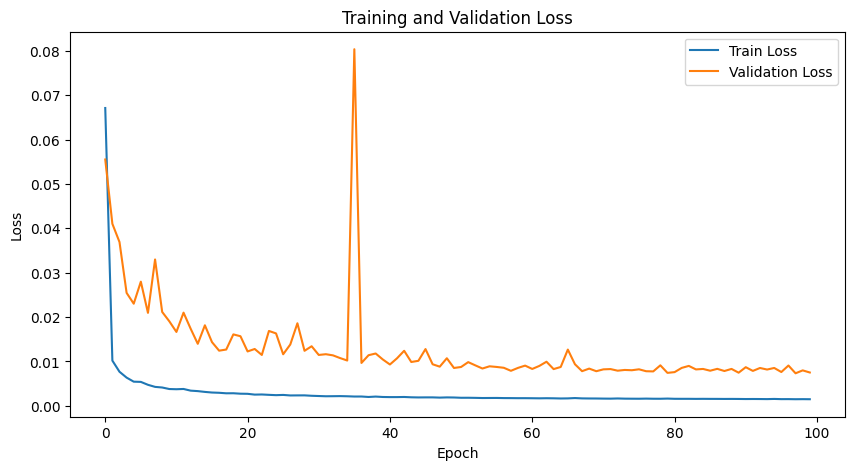

In [11]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

In [21]:
import numpy as np

real_image = np.load('dem.npz')['dem']
mask = np.load('dem.npz')['mask']
model = Unet()

for i in range(100):
    model.load_state_dict(torch.load(f'weigths/model_epoch_{i+1}.pth'))
    model.eval()
    model.cuda()
    testing(real_image, mask, i, 'cuda')

/tmp/ipykernel_688056/3076338858.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'weigths/model_epoch_{i+1}.pth'))
